# Tasks


*   Analysis of present condition
*   Exploring global data
*   Forecasting





In [2]:
import pandas as pd #handling tabular data
import numpy as np

import matplotlib.pyplot as plt #visualization
%matplotlib inline 
import seaborn as sns #visualizations
import plotly.express as px#visualizations
import plotly.graph_objects as go
import folium#maps ang geographical data
from folium import plugins

#change default plot size
plt.rcParams['figure.figsize'] = 10, 12

#disale warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#1 Analysis of present condition

### 1.1 Reading the data

In [3]:
df_pak = pd.read_excel('Pakistan.xlsx', sheet_name='TimeSeries_KeyIndicators')
df_pak['Date'] = pd.to_datetime(df_pak.Date)
df_pak['Date'] = df_pak['Date'].dt.strftime('%Y-%m-%d')

df_pak.columns

Index(['Unnamed: 0', 'Cumulative', 'Cumulative  Test positive',
       'Cumulative  tests performed', 'Date', 'Discharged', 'Expired',
       'Home Quarantine', 'New  (last 24 hrs)', 'Region', 'Still admitted',
       'Tests  performed in last 24 hours'],
      dtype='object')

###1.2 Analysing the cases

In [0]:
current_situation = df_pak[df_pak['Date'] == "2020-05-11"]

In [5]:
df = current_situation [['Region', 'Cumulative  Test positive', 'Expired', 'Still admitted']].reset_index(drop=True)

total_cases = current_situation['Cumulative  Test positive'].sum()

print(f'Total number of cases confirmed till 5-11-2020: {total_cases}')

Total number of cases confirmed till 5-11-2020: 30941


In [6]:
df.style.background_gradient(cmap='Reds')

,Region,Cumulative Test positive,Expired,Still admitted
0,AJK,86,0,22
1,Balochistan,2017,26,28
2,GB,442,4,5
3,ICT,679,6,28
4,KP,4669,245,641
5,Punjab,11568,197,4269
6,Sindh,11480,189,1237


###1.3 Active cases

In [7]:
current_situation['Active'] = (current_situation['Cumulative  Test positive'] - (current_situation['Discharged'] + current_situation['Expired']))

total_active = current_situation['Active'].sum()
print(f'Total number of active cases {total_active}')

total_cases = current_situation.groupby('Region')['Active'].sum().sort_values(ascending=False).to_frame()
total_cases.style.background_gradient(cmap='Reds')

Total number of active cases 22062


,Active
Region,
Sindh,9210
Punjab,7048
KP,3298
Balochistan,1749
ICT,601
GB,134
AJK,22


###1.4 Confirmed vs Recovered

        Region  Cumulative  Test positive  Expired  Discharged
5       Punjab                      11568      197        4323
6        Sindh                      11480      189        2081
4           KP                       4669      245        1126
1  Balochistan                       2017       26         242
3          ICT                        679        6          72
2           GB                        442        4         304
0          AJK                         86        0          64


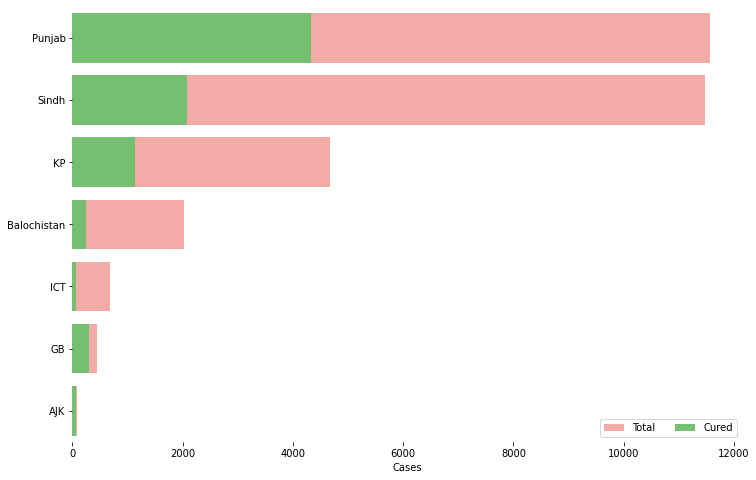

In [8]:
f, ax = plt.subplots(figsize=(12, 8))

data = current_situation[['Region', 'Cumulative  Test positive', 'Expired', 'Discharged']].reset_index(drop=True)
data.sort_values('Cumulative  Test positive', ascending=False, inplace=True)
print(data)

sns.set_color_codes('pastel')
sns.barplot(x='Cumulative  Test positive', y='Region', data=data, label='Total', color='r')

sns.set_color_codes('muted')
sns.barplot(x='Discharged', y='Region', data=data, label='Cured', color='g')

ax.legend(ncol=2, loc='lower right', frameon=True)
ax.set(ylabel="", xlabel="Cases")
sns.despine(left=True, bottom=True)

###1.5 Rise in cases

In [0]:
import plotly
plotly.io.renderers='colab'

In [10]:
data = df_pak.groupby('Date')['Cumulative  Test positive'].sum()
data = pd.DataFrame({'Date':data.index, 'Active':data.values})

fig = go.Figure()
fig.add_trace(go.Scatter(x = data['Date'] ,y = data['Active'], mode='lines+markers', name='Total cases'))
fig.update_layout(title='Trend of corona virus cases in Pakistan', plot_bgcolor='rgb(230, 230, 230)')
fig.show()

data = df_pak.groupby('Date')['New  (last 24 hrs)'].sum()
data = pd.DataFrame({'Date':data.index, 'New':data.values})

fig = px.bar(data, x='Date', y='New', barmode='group', height=400)
fig.update_layout(title_text='Corona Virus suspected cases in Pakistan on daily basis', plot_bgcolor='rgb(230, 230, 230)')
fig.show()

#2 Comaprison

###2.1 Reading Data

In [0]:
from functools import reduce

In [0]:
#Reading the data - Time series data with cumulative values
df_confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
df_death = pd.read_csv('time_series_covid19_deaths_global.csv')
df_recovered = pd.read_csv('time_series_covid19_recovered_global.csv')

###2.2 Processing data

In [0]:
#Renaming and Dropping columns
df_confirmed = df_confirmed.drop(columns=['Lat', 'Long']).rename(columns={'Country/Region': 'Country', 'Province/State': 'Province'})
df_death = df_death.drop(columns=['Lat', 'Long']).rename(columns={'Country/Region': 'Country', 'Province/State': 'Province'})
df_recovered = df_recovered.drop(columns=['Lat', 'Long']).rename(columns={'Country/Region': 'Country', 'Province/State': 'Province'})

In [0]:
#Convert wide range data to long range
df_confirmed = pd.melt(df_confirmed, id_vars=['Country', 'Province'], value_name='Confirmed', var_name='Date')
df_recovered = pd.melt(df_recovered, id_vars=['Country', 'Province'], value_name='Recovered', var_name='Date')
df_death = pd.melt(df_death, id_vars=['Country', 'Province'], value_name='Death', var_name='Date')

df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_death['Date'] = pd.to_datetime(df_death['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

In [0]:
#Combing the dataframes based on Province + Country + Date
df_merged = [df_confirmed, df_recovered, df_death]

df_merged = reduce(lambda left,right: pd.merge(left, right, on=['Country','Province', 'Date'], how ='inner'), df_merged).fillna('void')

In [16]:
df_merged.head()

,Country,Province,Date,Confirmed,Recovered,Death
0,Afghanistan,void,2020-01-22,0,0,0
1,Albania,void,2020-01-22,0,0,0
2,Algeria,void,2020-01-22,0,0,0
3,Andorra,void,2020-01-22,0,0,0
4,Angola,void,2020-01-22,0,0,0


In [17]:
#Get Pakistan's data
df_merged.query('Country == "Pakistan"').groupby('Date')[['Confirmed', 'Recovered', 'Death']].sum().reset_index()

,Date,Confirmed,Recovered,Death
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0
...,...,...,...,...
108,2020-05-09,28736,7809,636
109,2020-05-10,30334,8063,659
110,2020-05-11,32081,8555,706
111,2020-05-12,34336,8812,737


In [18]:
#Worldwide view
df_merged.groupby('Date')[['Confirmed', 'Recovered', 'Death']].sum().head().reset_index()

,Date,Confirmed,Recovered,Death
0,2020-01-22,555,28,17
1,2020-01-23,654,30,18
2,2020-01-24,941,36,26
3,2020-01-25,1434,39,42
4,2020-01-26,2117,52,56


###2.3 Visual Comarison

In [69]:
#PAKISTAN
fig = px.bar(df_merged.query('Country == "Pakistan"').groupby('Date')['Confirmed'].sum().reset_index(), x = 'Date', y ='Confirmed',
             color = 'Confirmed', orientation='v', height=600, title='Confirmed cases in Pakistan', 
             color_discrete_sequence=px.colors.cyclical.IceFire)

fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

#INDIA
fig = px.bar(df_merged.query('Country == "India"').groupby('Date')['Confirmed'].sum().reset_index(), x = 'Date', y ='Confirmed',
             color = 'Confirmed', orientation='v', height=600, title='Confirmed cases in India', 
             color_discrete_sequence=px.colors.cyclical.IceFire)

fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

#US
fig = px.bar(df_merged.query('Country == "US"').groupby('Date')['Confirmed'].sum().reset_index(), x = 'Date', y ='Confirmed',
             color = 'Confirmed', orientation='v', height=600, title='Confirmed cases in USA', 
             color_discrete_sequence=px.colors.cyclical.IceFire)

fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

#ITALY
fig = px.bar(df_merged.query('Country == "Italy"').groupby('Date')['Confirmed'].sum().reset_index(), x = 'Date', y ='Confirmed',
             color = 'Confirmed', orientation='v', height=600, title='Confirmed cases in Italy', 
             color_discrete_sequence=px.colors.cyclical.IceFire)

fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

In [84]:
from plotly.subplots import make_subplots

fig = make_subplots(
      rows = 2, cols = 2,
      specs = [[{}, {}],
              [{}, {}]],
      subplot_titles = ('Pakistan', 'India', 'US', 'Italy'))

df = df_merged.query('Country == "Pakistan"').groupby('Date')['Confirmed'].sum().reset_index()
fig.add_trace(go.Bar(x = df['Date'], y = df['Confirmed'], marker = dict(color =df['Confirmed'],
                     coloraxis ='coloraxis')),1,1)

df = df_merged.query('Country == "India"').groupby('Date')['Confirmed'].sum().reset_index()
fig.add_trace(go.Bar(x = df['Date'], y = df['Confirmed'], marker = dict(color =df['Confirmed'],
                     coloraxis ='coloraxis')),1,2)

df = df_merged.query('Country == "US"').groupby('Date')['Confirmed'].sum().reset_index()
fig.add_trace(go.Bar(x = df['Date'], y = df['Confirmed'], marker = dict(color =df['Confirmed'],
                     coloraxis ='coloraxis')),2,1)

df = df_merged.query('Country == "Italy"').groupby('Date')['Confirmed'].sum().reset_index()
fig.add_trace(go.Bar(x = df['Date'], y = df['Confirmed'], marker = dict(color =df['Confirmed'],
                     coloraxis ='coloraxis')),2,2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False, title_text="TOTAL Confirmed cases") 

fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

###2.4 Plotting World data

In [0]:
confirmed = df_merged.groupby('Date')['Confirmed'].sum().reset_index()
recovered = df_merged.groupby('Date')['Recovered'].sum().reset_index()
death = df_merged.groupby('Date')['Death'].sum().reset_index()

In [20]:
fig = go.Figure()
#plotting datewise confimred cases
fig.add_trace(go.Scatter(x=confirmed['Date'], y=confirmed['Confirmed'], mode='lines+markers', name='Confirmed', line=dict(color='Blue', width=2)))
fig.add_trace(go.Scatter(x=recovered['Date'], y=recovered['Recovered'], mode='lines+markers', name='Recovered', line=dict(color='Green', width=2)))
fig.add_trace(go.Scatter(x=death['Date'], y=death['Death'], mode='lines+markers', name='Death', line=dict(color='Red', width=2)))

fig.update_layout(title='Worldwise COVID-19 cases', xaxis_tickfont_size=14,yaxis=dict(title='Number of Cases'))
fig.show()

#3 Forecasting

In [0]:
from fbprophet import Prophet

In [0]:
confirmed = df_merged.groupby('Date')['Confirmed'].sum().reset_index()
recovered = df_merged.groupby('Date')['Recovered'].sum().reset_index()
death = df_merged.groupby('Date')['Death'].sum().reset_index()

In [0]:
confirmed.columns = ['ds', 'y']

In [24]:
confirmed.tail()

,ds,y
108,2020-05-09,3955091
109,2020-05-10,4031608
110,2020-05-11,4106238
111,2020-05-12,4189328
112,2020-05-13,4273450


###3.1 Forecasting confirmed cases worldwide

Generating a week ahead forecast of confirmed cases of NCOVID-19 using Prophet, with 95% prediction interval by creating a base model with no tweaking of seasonality-related parameters and additional regressors.

In [43]:
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=7)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
115,2020-05-16
116,2020-05-17
117,2020-05-18
118,2020-05-19
119,2020-05-20


The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [44]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
115,2020-05-16,4.499469e+06,4.480612e+06,4.520848e+06
116,2020-05-17,4.579061e+06,4.549579e+06,4.608500e+06
117,2020-05-18,4.655410e+06,4.620847e+06,4.693350e+06
118,2020-05-19,4.732217e+06,4.684330e+06,4.785232e+06
119,2020-05-20,4.811964e+06,4.757578e+06,4.880648e+06


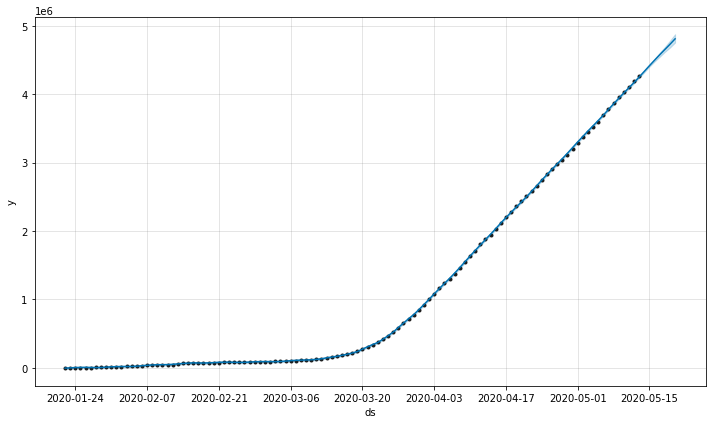

In [45]:
confirmed_m_forecast_plot = m.plot(forecast)

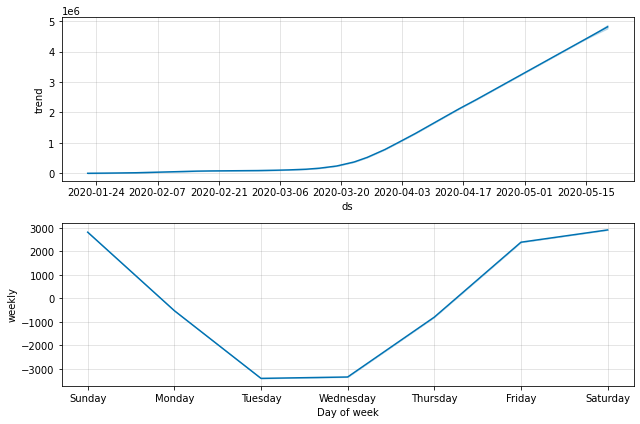

In [46]:
confirmed_m_forecast_plot = m.plot_components(forecast)

###3.2 Forecasting worldwide deaths

In [0]:
death.columns = ['ds', 'y']

In [54]:
m = Prophet(interval_width=0.95)
m.fit(death)
future = m.make_future_dataframe(periods=7)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
115,2020-05-16
116,2020-05-17
117,2020-05-18
118,2020-05-19
119,2020-05-20


In [56]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
115,2020-05-16,310757.802775,308508.759997,312857.873503
116,2020-05-17,315315.562285,312347.653728,317921.241635
117,2020-05-18,320069.716327,315907.537033,323279.502307
118,2020-05-19,325483.838099,320242.037365,329853.816922
119,2020-05-20,331046.182924,324844.053156,336371.794609


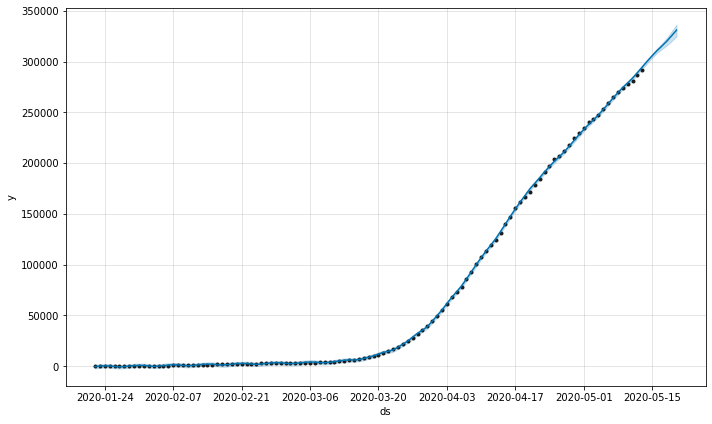

In [57]:
death_m_forecast_plot = m.plot(forecast)

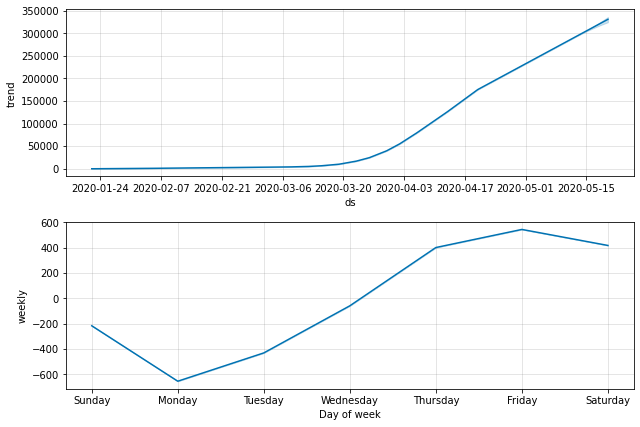

In [58]:
death_m_forecast_plot = m.plot_components(forecast)

###3.3 Forcasting worldwide recovered

In [0]:
recovered.columns = ['ds', 'y']

In [61]:
m = Prophet(interval_width=0.95)
m.fit(recovered)
future = m.make_future_dataframe(periods=7)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
115,2020-05-16
116,2020-05-17
117,2020-05-18
118,2020-05-19
119,2020-05-20


In [62]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
115,2020-05-16,1.599882e+06,1.584704e+06,1.614737e+06
116,2020-05-17,1.636121e+06,1.619435e+06,1.653331e+06
117,2020-05-18,1.673416e+06,1.656852e+06,1.692676e+06
118,2020-05-19,1.710413e+06,1.690432e+06,1.732794e+06
119,2020-05-20,1.750428e+06,1.725141e+06,1.775204e+06


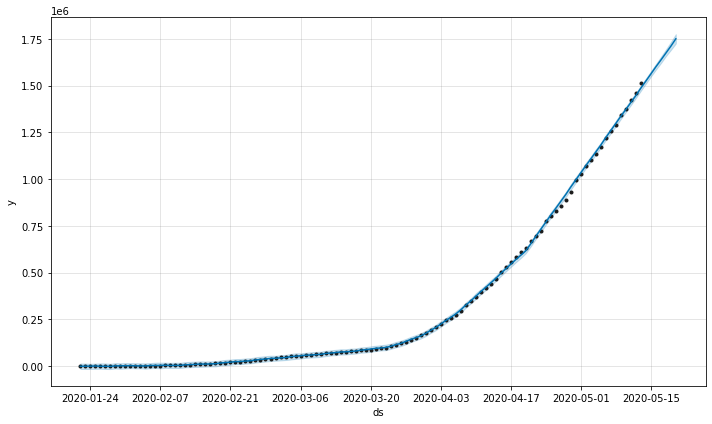

In [63]:
death_m_forecast_plot = m.plot(forecast)

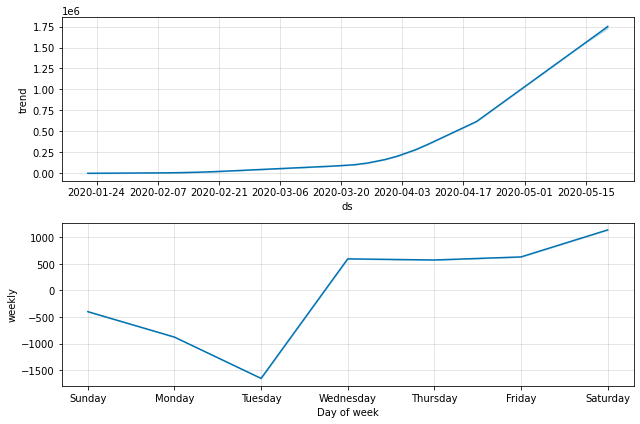

In [64]:
death_m_forecast_plot = m.plot_components(forecast)

###3.3 Inference

Pakistan is following the trajectory of countires like Italy and US